Text(0.5, 1.0, 'bins = [-2,-1,-0.5,0,1,4,6]')

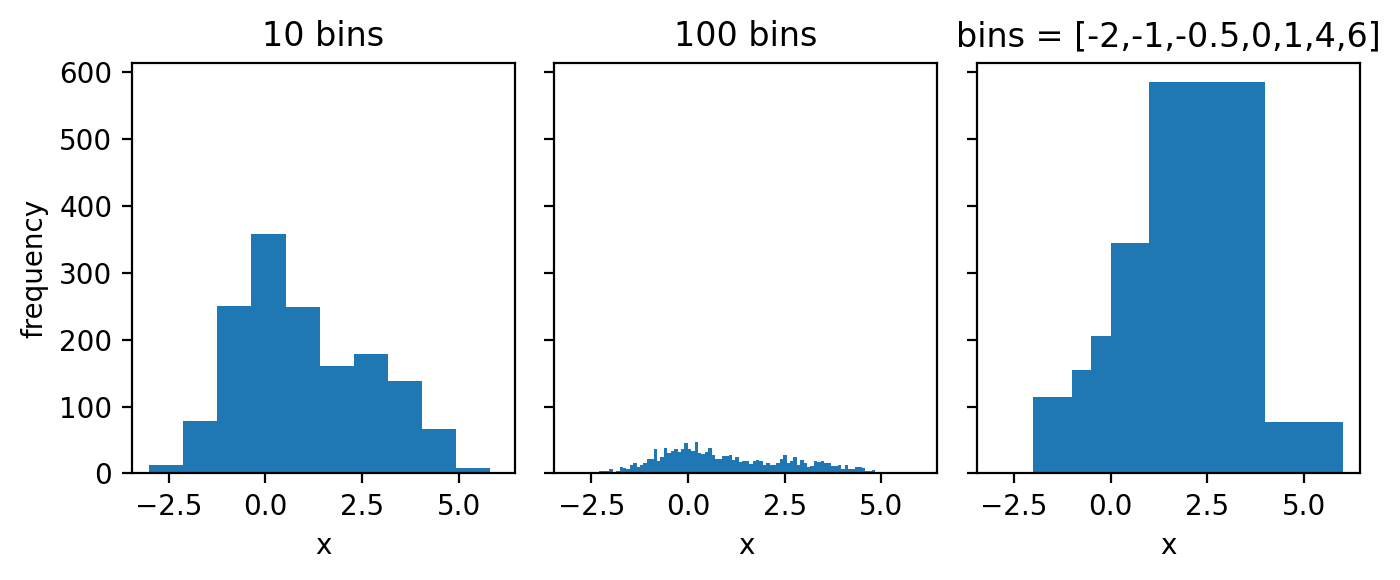

In [22]:
import numpy as np
import matplotlib.pyplot as plt

subplot_settings = dict(figsize=[7, 3], dpi=200, tight_layout=True)
num_points = 1000
data = np.concatenate(
    (np.random.normal(size=num_points), np.random.normal(size=num_points // 2) + 3)
)
fig, axs = plt.subplots(1, 3, **subplot_settings, sharex=True, sharey=True)
ax = axs[0]
ax.hist(data, bins=10)
ax.set_ylabel("frequency")
ax.set_xlabel("x")
ax.set_title("10 uniform bins")
ax = axs[1]
ax.hist(data, bins=100)
ax.set_xlabel("x")
ax.set_title("100 uniform bins")
ax = axs[2]
ax.hist(data, bins=[-2, -1, -0.5, 0, 1, 4, 6])
ax.set_xlabel("x")
ax.set_title("bins = [-2,-1,-0.5,0,1,4,6]")

Text(0.5, 1.0, 'bandwidth = 1')

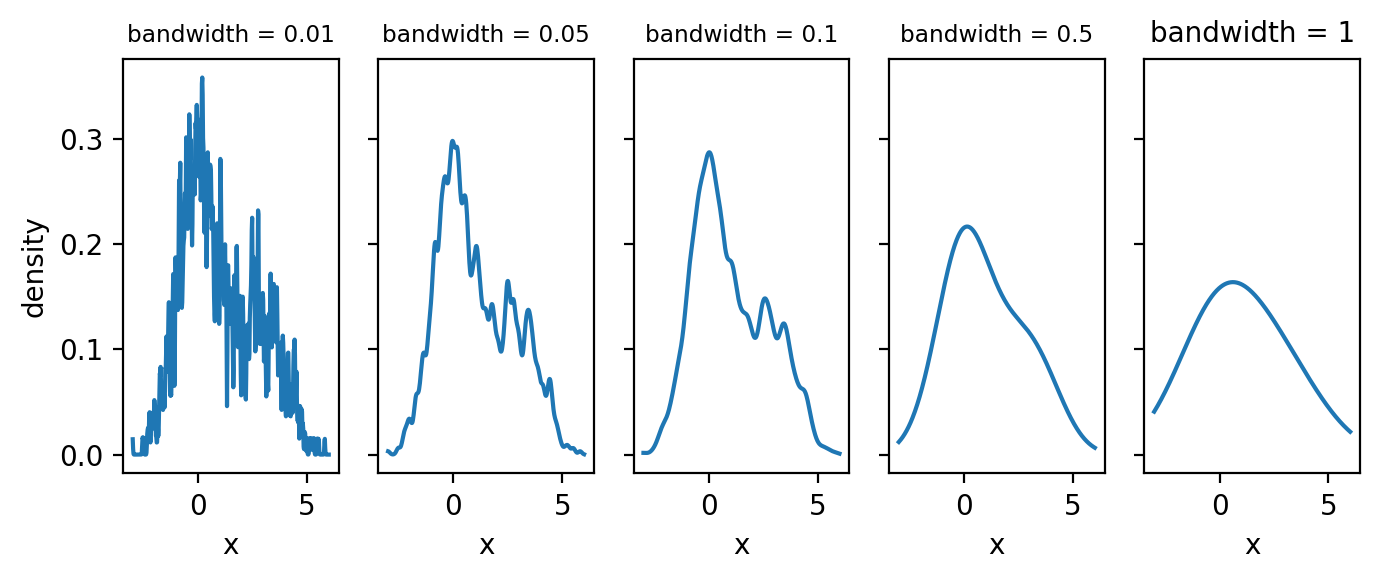

In [39]:
from scipy.stats import gaussian_kde

grid = np.linspace(-3, 6, 500)

fig, axs = plt.subplots(1, 5, **subplot_settings, sharex=True, sharey=True)
ax = axs[0]
kde = gaussian_kde(data, bw_method=0.01)
ax.plot(grid, kde.pdf(grid))
ax.set_ylabel("density")
ax.set_xlabel("x")
ax.set_title("bandwidth = 0.01", fontsize="small")
ax = axs[1]
kde = gaussian_kde(data, bw_method=0.05)
ax.plot(grid, kde.pdf(grid))
ax.set_xlabel("x")
ax.set_title("bandwidth = 0.05", fontsize="small")
ax = axs[2]
kde = gaussian_kde(data, bw_method=0.1)
ax.plot(grid, kde.pdf(grid))
ax.set_xlabel("x")
ax.set_title("bandwidth = 0.1", fontsize="small")
ax = axs[3]
kde = gaussian_kde(data, bw_method=0.5)
ax.plot(grid, kde.pdf(grid))
ax.set_xlabel("x")
ax.set_title("bandwidth = 0.5", fontsize="small")
ax = axs[4]
kde = gaussian_kde(data, bw_method=1)
ax.plot(grid, kde.pdf(grid))
ax.set_xlabel("x")
ax.set_title("bandwidth = 1", fontsize="medium")

Text(0.5, 1.0, 'Likelihood for $x =x_0 =10$')

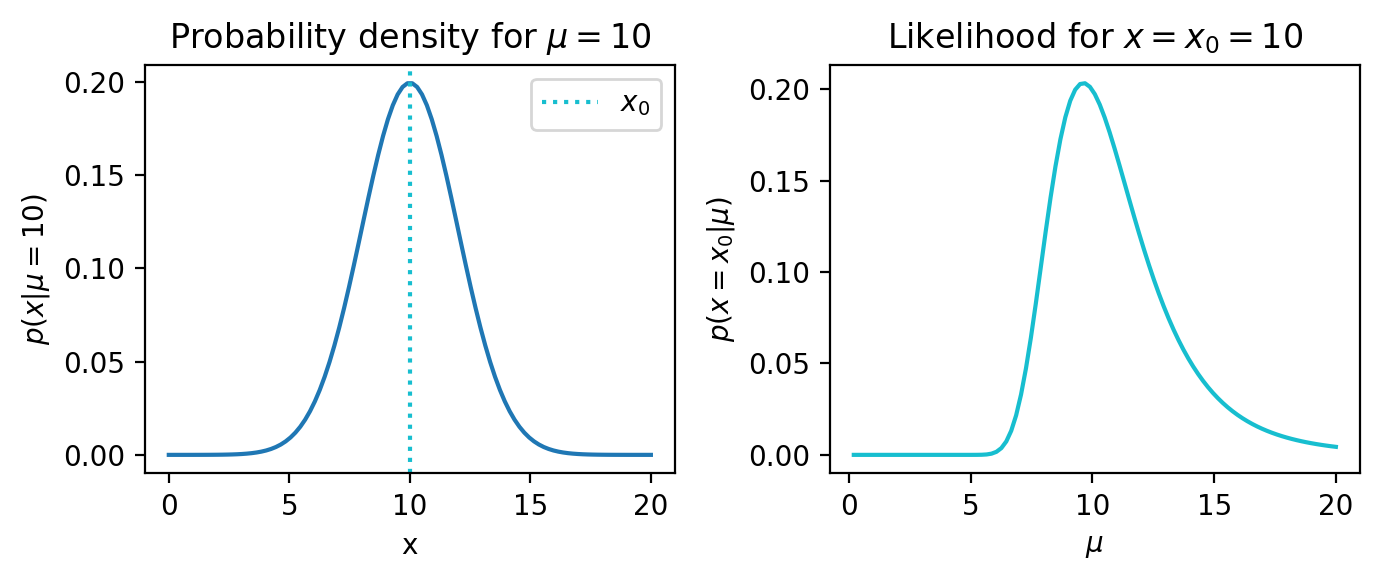

In [55]:
import jax
import jax.numpy as jnp
import jax.scipy as jsc
from jaxopt import OptaxSolver
from optax import adam
import matplotlib.pyplot as plt

subplot_settings = dict(figsize=[7, 3], dpi=200, tight_layout=True)


def pdf(x, mu):
    return jsc.stats.norm.pdf(x, mu, 0.2 * mu)


mu = 10
x0 = 10

grid = jnp.linspace(0, 20, 100)

fig, axs = plt.subplots(1, 2, **subplot_settings)

ax = axs[0]
ax.plot(grid, pdf(grid, mu))
ax.axvline(x0, label="$x_0$", linestyle="dotted", color="C9")
ax.set_xlabel("x")
ax.set_ylabel("$p(x|\mu=10)$")
ax.legend()
ax.set_title("Probability density for $\mu =10$")
ax = axs[1]
ax.plot(grid, jax.vmap(pdf, in_axes=(None, 0))(x0, grid), color="C9")
ax.set_xlabel("$\mu$")
ax.set_ylabel("$p(x=x_0|\mu)$")
ax.set_title("Likelihood for $x =x_0 =10$")

In [56]:
def central_interval(data, conf_level, inits):
    level = 1 - (1 - conf_level) / 2

    def solve(init, level):
        def loss(mu):
            return (level - jsc.stats.norm.cdf(data, mu, mu * 0.2)) ** 2

        solver = OptaxSolver(loss, adam(1e-3), tol=1e-8, maxiter=1e5)
        return solver.run(init).params

    lower = solve(inits[0], level)
    upper = solve(inits[1], 1 - level)

    return lower, upper


mu1, mu2 = central_interval(x0, 0.683, [5.0, 5.0])

In [57]:
mu1, mu2

(DeviceArray(8.332443, dtype=float32), DeviceArray(12.502007, dtype=float32))

Text(0.5, 1.0, '$\\mu=\\mu_{\\mathrm{upper}} = $12.5')

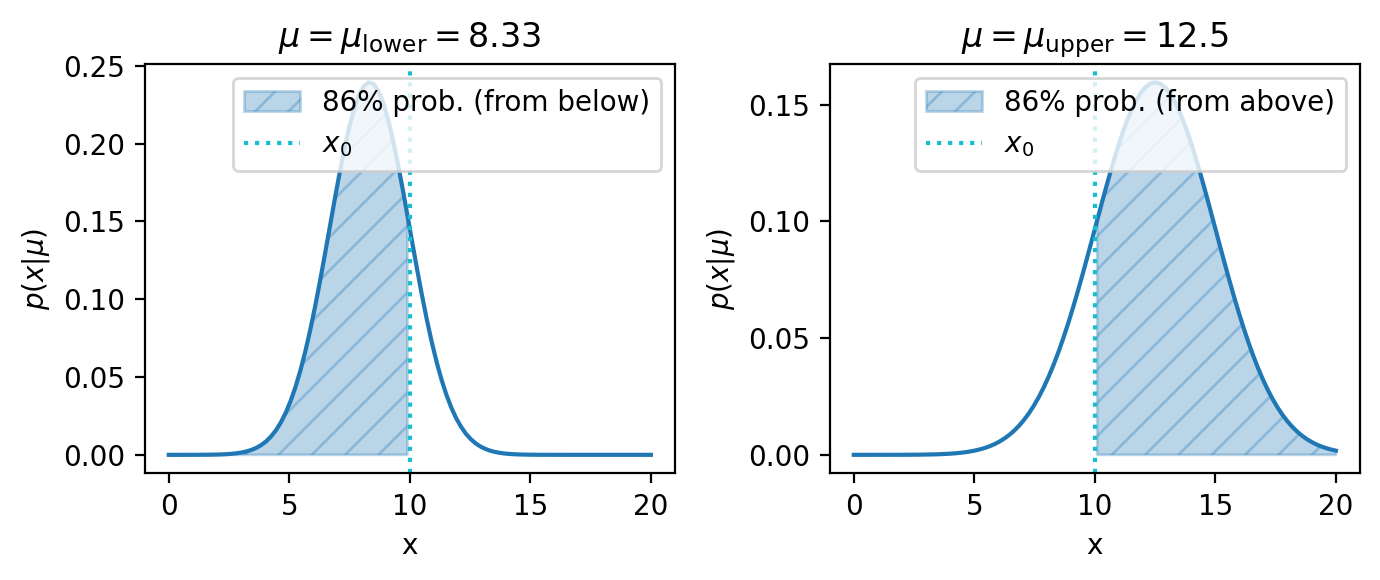

In [58]:
fig, axs = plt.subplots(1, 2, **subplot_settings)

ax = axs[0]
ax.plot(grid, pdf(grid, mu1))
ax.fill_between(
    grid[grid < x0],
    0,
    pdf(grid[grid < x0], mu1),
    hatch="//",
    edgecolor="C0",
    alpha=0.3,
    label="86% prob. (from below)",
)
ax.axvline(x0, label="$x_0$", linestyle="dotted", color="C9")
ax.set_xlabel("x")
ax.set_ylabel("$p(x|\mu)$")
ax.legend(loc="upper right")
ax.set_title(r"$\mu=\mu_{\mathrm{lower}} = $" + f"{mu1:.3g}")
ax = axs[1]
ax.plot(grid, pdf(grid, mu2))
ax.fill_between(
    grid[grid > x0],
    0,
    pdf(grid[grid > x0], mu2),
    hatch="//",
    edgecolor="C0",
    alpha=0.3,
    label="86% prob. (from above)",
)
ax.axvline(x0, label="$x_0$", linestyle="dotted", color="C9")
ax.set_xlabel("x")
ax.set_ylabel("$p(x|\mu)$")
ax.legend(loc="upper right")
ax.set_title(r"$\mu=\mu_{\mathrm{upper}} = $" + f"{mu2:.3g}")

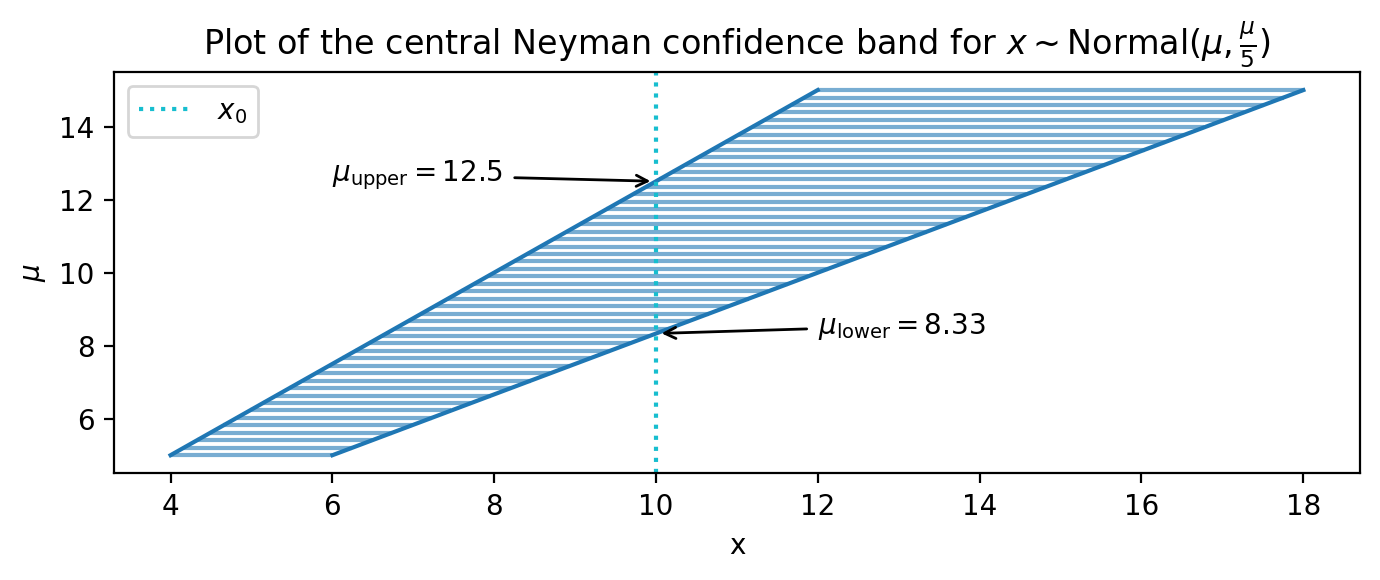

In [59]:
from functools import partial


def central_acceptance_interval(mu, conf_level, inits):
    level = 1 - (1 - conf_level) / 2

    def solve(init, level):
        def loss(data):
            return (level - jsc.stats.norm.cdf(data, mu, mu * 0.2)) ** 2

        solver = OptaxSolver(loss, adam(1e-3), tol=1e-8, maxiter=1e5)
        return solver.run(init).params

    lower = solve(inits[0], level)
    upper = solve(inits[1], 1 - level)

    return lower, upper


def neyman_interval(mu_grid, conf_level, inits):
    central = jax.vmap(central_acceptance_interval, in_axes=(0, None, None))
    return central(mu_grid, conf_level, inits)


mu_grid = jnp.linspace(5, 15, 50)
x1, x2 = neyman_interval(mu_grid, 0.683, [1.0, 1.0])
fig, ax = plt.subplots(**subplot_settings)
ax.plot(x1, mu_grid, color="C0")
ax.plot(x2, mu_grid, color="C0")
ax.set_xlabel("x")
ax.set_ylabel("$\mu$")
ax.hlines(mu_grid, x1, x2, alpha=0.6)
ax.axvline(x0, label="$x_0$", linestyle="dotted", color="C9")
# ax.hlines(mu2, min(x2), 10, color='red', linestyles='dashed')
# ax.hlines(mu1, 10, max(x1), color='red', linestyles='dashed')
ax.annotate(
    r"$\mu_{\mathrm{upper}} = $" + f"{mu2:.3g}",
    xy=(10, mu2),
    xytext=(6, mu2),
    arrowprops=dict(arrowstyle="->"),
)
ax.annotate(
    r"$\mu_{\mathrm{lower}} = $" + f"{mu1:.3g}",
    xy=(10, mu1),
    xytext=(12, mu1),
    arrowprops=dict(arrowstyle="->"),
)
ax.set_title(
    r"Plot of the central Neyman confidence band for $x\sim\mathrm{Normal}(\mu, \frac{\mu}{5})$"
)
ax.legend();

In [60]:
from functools import partial


def central_acceptance_interval(mu, conf_level, inits):
    level = 1 - (1 - conf_level) / 2

    def solve(init, level):
        def loss(data):
            return (level - jsc.stats.norm.cdf(data, mu, mu * 0.2)) ** 2

        loss, _ = jax.closure_convert(loss, init)
        solver = OptaxSolver(
            loss, adam(1e-3), tol=1e-8, maxiter=1e5, implicit_diff=True
        )
        return solver.run(init).params

    lower = solve(inits[0], level)
    upper = solve(inits[1], 1 - level)

    return lower, upper


def neyman_interval(mu_grid, conf_level, inits):
    central = jax.vmap(central_acceptance_interval, in_axes=(0, None, None))
    return central(mu_grid, conf_level, inits)


mu_grid = jnp.linspace(5, 15, 50)
jax.grad(neyman_interval)(mu_grid, 0.683, [1.0, 1.0])
fig, ax = plt.subplots(**subplot_settings)
ax.plot(x1, mu_grid, color="C0")
ax.plot(x2, mu_grid, color="C0")
ax.set_xlabel("x")
ax.set_ylabel("$\mu$")
ax.hlines(mu_grid, x1, x2, alpha=0.6)
ax.axvline(x0, label="$x_0$", linestyle="dotted", color="C9")
# ax.hlines(mu2, min(x2), 10, color='red', linestyles='dashed')
# ax.hlines(mu1, 10, max(x1), color='red', linestyles='dashed')
ax.annotate(
    r"$\mu_{\mathrm{upper}} = $" + f"{mu2:.3g}",
    xy=(10, mu2),
    xytext=(6, mu2),
    arrowprops=dict(arrowstyle="->"),
)
ax.annotate(
    r"$\mu_{\mathrm{lower}} = $" + f"{mu1:.3g}",
    xy=(10, mu1),
    xytext=(12, mu1),
    arrowprops=dict(arrowstyle="->"),
)
ax.set_title(
    r"Plot of the central Neyman confidence band for $x\sim\mathrm{Normal}(\mu, \frac{\mu}{5})$"
)
ax.legend();

AssertionError: 